In [1]:
from src.visualizer import visualize_dataset, visualize_dataloader, visualize_results
from src.loops import ModelTrainer
from src.Data.get_dataset import download_VOC
from src.Data.get_dataloader import get_dataloader 
from src.models.resnet_image import ResNet6_images
from src.utils.dice_loss import dice_loss
from src.models.node_image import ODENet
from src.models.rknet_image import RKNet

In [2]:
import torch
if torch.cuda.is_available(): 
    dev = "cuda" 
else: 
    dev = "cpu"
    print("only cpu available") 
device = torch.device(dev) 

In [3]:
voc_trainset, voc_valset = download_VOC()

Using downloaded and verified file: C:\Users\tobia\OneDrive\Dokumente\GitHub\DL4SC_Neural_ODEs\Image_segmentation\src\Data\data_set\VOCtrainval_11-May-2012.tar
Extracting C:\Users\tobia\OneDrive\Dokumente\GitHub\DL4SC_Neural_ODEs\Image_segmentation\src\Data\data_set\VOCtrainval_11-May-2012.tar to C:\Users\tobia\OneDrive\Dokumente\GitHub\DL4SC_Neural_ODEs\Image_segmentation\src\Data\data_set
Using downloaded and verified file: C:\Users\tobia\OneDrive\Dokumente\GitHub\DL4SC_Neural_ODEs\Image_segmentation\src\Data\data_set\VOCtrainval_11-May-2012.tar
Extracting C:\Users\tobia\OneDrive\Dokumente\GitHub\DL4SC_Neural_ODEs\Image_segmentation\src\Data\data_set\VOCtrainval_11-May-2012.tar to C:\Users\tobia\OneDrive\Dokumente\GitHub\DL4SC_Neural_ODEs\Image_segmentation\src\Data\data_set


In [24]:
verbose = True
load = True
run_tasks = True
save = True
test_tasks = True

In [25]:
import numpy as np
if verbose:
    possible_val = np.empty((0))
    for i in range(len(voc_trainset)):
        image, mask = voc_trainset[i]
        possible_val = np.unique(np.append(possible_val, np.unique(mask)))
    print(possible_val)
    print("unique number in masks ", len(possible_val))

[  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
  14.  15.  16.  17.  18.  19.  20. 255.]
unique number in masks  22


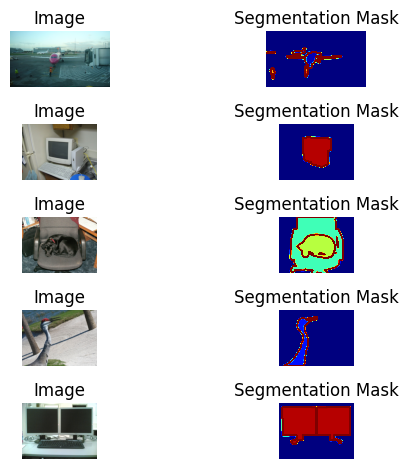

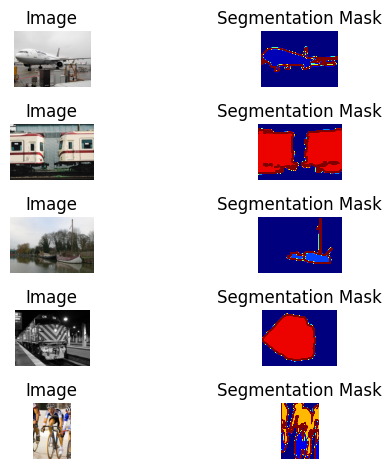

In [26]:
if verbose:
    visualize_dataset(voc_trainset)
    visualize_dataset(voc_valset)

In [27]:
voc_train_loader = get_dataloader(voc_trainset, out_size=256, batch_size=16)
voc_val_loader = get_dataloader(voc_valset, out_size=256, batch_size=16)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


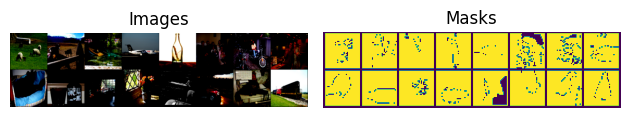

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


images shape:  torch.Size([16, 3, 256, 256])
masks shape:  torch.Size([16, 21, 32, 32])


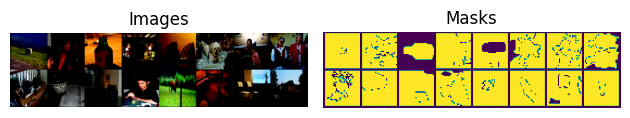

images shape:  torch.Size([16, 3, 256, 256])
masks shape:  torch.Size([16, 21, 32, 32])


In [28]:
if verbose:
    visualize_dataloader(voc_train_loader)
    visualize_dataloader(voc_val_loader)

In [47]:
import os
import torch.nn as nn
in_channels = 3
out_channels = 21
model_resnet = ResNet6_images(in_channels, out_channels).to(device)
model_node = ODENet(in_channels, out_channels).to(device)
model_rknet = RKNet(in_channels, out_channels).to(device)
weights = torch.ones(21).to(device) * 10. # 10x the loss of classes instead of nothing
weights[0] = 1.
lossf = torch.nn.BCEWithLogitsLoss(pos_weight=weights) #nn.CrossEntropyLoss(weight=weights) 
learning_rate = 0.001
num_epochs = 50
print_interval = 25
model_filepath =  os.path.join(os.getcwd(), "src\\model_trained\\" ) 

In [48]:
trainer_resnet = ModelTrainer(voc_train_loader, voc_val_loader, model_resnet, lossf, learning_rate, num_epochs, print_interval, os.path.join(model_filepath, "resnet.pt" ), device)
trainer_node = ModelTrainer(voc_train_loader, voc_val_loader, model_node, lossf, learning_rate, num_epochs, print_interval, os.path.join(model_filepath, "node.pt"), device)
trainer_rknet = ModelTrainer(voc_train_loader, voc_val_loader, model_rknet, lossf, learning_rate, num_epochs, print_interval, os.path.join(model_filepath, "rknet.pt"), device)

In [49]:
if load:
    trainer_resnet.load_model()
    trainer_node.load_model()
    trainer_rknet.load_model()

Model loaded successfully from c:\Users\tobia\OneDrive\Dokumente\GitHub\DL4SC_Neural_ODEs\Image_segmentation\src\model_trained\resnet.pt
Model loaded successfully from c:\Users\tobia\OneDrive\Dokumente\GitHub\DL4SC_Neural_ODEs\Image_segmentation\src\model_trained\node.pt
Model loaded successfully from c:\Users\tobia\OneDrive\Dokumente\GitHub\DL4SC_Neural_ODEs\Image_segmentation\src\model_trained\rknet.pt


In [50]:
if run_tasks:
    for cur_model in [trainer_resnet]: #, trainer_node, trainer_rknet]: 
        cur_model.train()
        if save:
            cur_model.save_model()

Epoch [1/50], Evaluation [25/92], Loss: 3.539938488006592
Epoch [1/50], Evaluation [50/92], Loss: 3.4943885612487793
Epoch [1/50], Evaluation [75/92], Loss: 3.5213091278076174
Epoch [1/50], Evaluation [92/92], Loss: 3.4814909626455868
Epoch [2/50], Evaluation [25/92], Loss: 3.46606671333313
Epoch [2/50], Evaluation [50/92], Loss: 3.4463694286346436
Epoch [2/50], Evaluation [75/92], Loss: 3.5600751781463624
Epoch [2/50], Evaluation [92/92], Loss: 3.6685042100794174
Epoch [3/50], Evaluation [25/92], Loss: 3.4756057357788084
Epoch [3/50], Evaluation [50/92], Loss: 3.5366419696807863
Epoch [3/50], Evaluation [75/92], Loss: 3.474995107650757
Epoch [3/50], Evaluation [92/92], Loss: 3.6310276844922234
Epoch [4/50], Evaluation [25/92], Loss: 3.3886896896362306
Epoch [4/50], Evaluation [50/92], Loss: 3.566062126159668
Epoch [4/50], Evaluation [75/92], Loss: 3.534404535293579
Epoch [4/50], Evaluation [92/92], Loss: 3.557735429090612
Epoch [5/50], Evaluation [25/92], Loss: 3.5947218132019043
Epoc

In [51]:
if test_tasks:
    trainer_resnet.test()
    trainer_node.test() 
    trainer_rknet.test()

Test Loss: 3.48
Test Loss: 3.46
Test Loss: 3.51


In [ ]:
if verbose:
    predicts, masks = trainer_resnet.predict()
    print("resnet")
    visualize_results(predicts, masks)
    print("----------------------------")

    predicts, masks = trainer_node.predict()
    print("node")
    visualize_results(predicts, masks)
    print("----------------------------")

    predicts, masks = trainer_rknet.predict()
    print("rknet")
    visualize_results(predicts, masks)
    print("----------------------------")